In [39]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer 
from scipy import stats

from psyfun import io, atlas, spikes, util
from psyfun.config import paths, cmaps

In [2]:
df_sessions = pd.read_csv(paths['sessions'])  # session info
df_sessions = io.add_postLSD_epochs(df_sessions)
df_units = pd.read_parquet(paths['units'])  # unit info

In [3]:
df_sessions['year'] = df_sessions['start_time'].apply(lambda x: datetime.fromisoformat(x).year)
df_sessions = df_sessions.query('year < 2025')

In [4]:
# Get eids for sessions with both tasks
df_sessionquery = df_sessions.query('n_tasks == 2')
eids = df_sessionquery['eid'].tolist()

# Find good-quality units from those sessions
df_unitquery = df_units.query('eid in @eids and ks2_label == "good"')
# Load spike times for good units
uuids = df_unitquery['uuid']
df_spiketimes = io.load_units(paths['spikes'], uuids)
# Join spike times with unit info
df_spikes = df_unitquery.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessionquery, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns
df_spikes = df_spikes[[col for col in df_spikes.columns if not col.endswith('_x') or col.endswith('_y')]]
df_spikes['region'] = df_spikes['region'].replace({'none':np.nan})

100%|█████████████████████████████████████| 9697/9697 [00:02<00:00, 3562.31it/s]


In [5]:
# Get spike counts for epochs of interest
epochs = ['task00_spontaneous', 'LSD0', 'LSD600', 'LSD1200', 'task01_spontaneous']
dt = 1  # get spike counts in 1s bins

for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())

Getting spike counts for: task00_spontaneous


100%|█████████████████████████████████████| 9697/9697 [00:02<00:00, 3352.87it/s]


Getting spike counts for: LSD0


100%|█████████████████████████████████████| 9697/9697 [00:02<00:00, 3710.13it/s]


Getting spike counts for: LSD600


100%|█████████████████████████████████████| 9697/9697 [00:02<00:00, 3541.32it/s]


Getting spike counts for: LSD1200


100%|█████████████████████████████████████| 9697/9697 [00:02<00:00, 3947.65it/s]


Getting spike counts for: task01_spontaneous


100%|█████████████████████████████████████| 9697/9697 [00:02<00:00, 3775.68it/s]


In [7]:
columns_to_keep = ['subject', 'eid', 'session_n']

pca_results = []
for idx, session in df_spikes.groupby('eid'):
    session_data = {col: session[col].unique()[0] for col in columns_to_keep}
    for task in ['task00', 'task01']:
        X = np.column_stack(session[f'{task}_spontaneous_counts'])
        transformer = PowerTransformer(method='yeo-johnson', standardize=True)
        X_rescaled = transformer.fit_transform(X)
        pca = PCA()
        X_pcs = pca.fit_transform(X)
        session_data[f'{task}_eigenspectrum'] = pca.explained_variance_ratio_
        session_data[f'{task}_loadings'] = pca.components_
    pca_results.append(session_data)
df_pca = pd.DataFrame(pca_results)

In [52]:
for task in ['task00', 'task01']:
    df_pca[f'{task}_pc1'] = df_pca[f'{task}_eigenspectrum'].apply(lambda x: x[0])
    df_pca[f'{task}_n80'] = df_pca[f'{task}_eigenspectrum'].apply(lambda x: np.cumsum(x).searchsorted(0.8))
    df_pca[f'{task}_powlaw'] = df_pca[f'{task}_eigenspectrum'].apply(util.power_law_slope)
    df_pca[f'{task}_ngsc'] = df_pca[f'{task}_eigenspectrum'].apply(util.ngsc)
    # Note: exponential/ bi-exponential fits often poorly characterize these eigenspectra
    # df_pca[f'{task}_tau'] = df_pca[f'{task}_eigenspectrum'].apply(_get_exp_tau)
    # df_pca[f'{task}_lifetime'] = df_pca[f'{task}_eigenspectrum'].apply(_get_biexp_mean_lifetime)

Text(0.6, 0.05, 'p=1.51e-01')

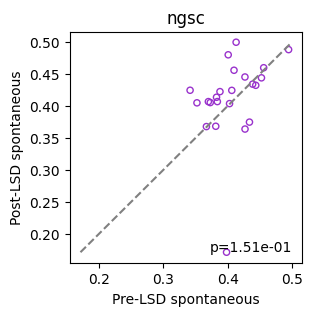

In [58]:
# for val in ['pc1', 'n80', 'powlaw', 'ngsc']:
val = 'ngsc'
fig, ax = plt.subplots(figsize=(3, 3))
ax.set_title(val)
xx = df_pca[f'task00_{val}']
yy = df_pca[f'task01_{val}']
ax.scatter(xx, yy, s=20, fc='none', ec=cmaps['LSD'](1.))
data_range = (min(xx.min(), yy.min()), max(xx.max(), yy.max()))
ax.plot([data_range[0], data_range[1]], [data_range[0], data_range[1]], ls='--', color='gray')
ax.set_xlabel('Pre-LSD spontaneous')
ax.set_ylabel('Post-LSD spontaneous')
w, p = stats.wilcoxon(xx, yy)
ax.text(0.6, 0.05, f'p={p:.2e}', transform=ax.transAxes)

In [60]:
def angle(v1, v2):
    """
    Compute the angle between two vectors v1 and v2.
    
    Parameters
    ----------
    v1, v2 : array_like
        The two vectors (e.g. PC1 directions) between which to compute the angle.
    
    Returns
    -------
    angle_rad : float
        Angle in radians.
    angle_deg : float
        Angle in degrees.
    """
    # Compute dot product and norms.
    dot = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # Avoid numerical issues: clip the cosine value to the valid range [-1, 1]
    cos_theta = np.clip(dot / (norm_v1 * norm_v2), -1.0, 1.0)
    angle_rad = np.arccos(cos_theta)
    # angle_deg = np.degrees(angle_rad)
    return angle_rad

In [66]:
df_pca['pc1_angle'] = df_pca.apply(lambda x: angle(x['task00_loadings'][0], x['task01_loadings'][0]), axis='columns') 

[]

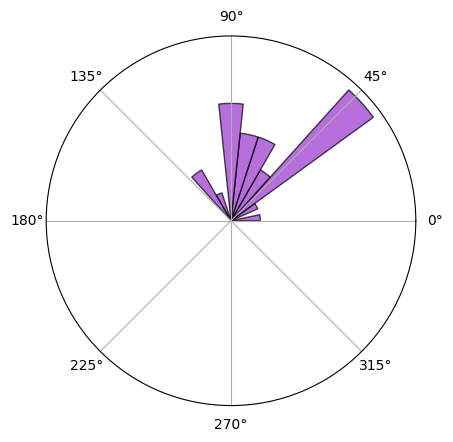

In [73]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Define number of bins for the histogram
num_bins = 30
bins = np.linspace(0, 2*np.pi, num_bins + 1)
# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2.0
width = 2 * np.pi / num_bins

# Compute histogram counts (frequency for each bin)
counts, _ = np.histogram(df_pca['pc1_angle'], bins=bins)

# Plot the histogram as bars on the polar plot
ax.bar(bin_centers, counts, width=width, align='center', alpha=0.7, fc=cmaps['LSD'](1.), ec='black')
ax.set_yticks([])
# ax.set_title('PC1 rotation')

(array([1., 0., 3., 5., 3., 3., 4., 1., 0., 3.]),
 array([  6.10622088,  18.40197361,  30.69772634,  42.99347906,
         55.28923179,  67.58498451,  79.88073724,  92.17648997,
        104.47224269, 116.76799542, 129.06374814]),
 <BarContainer object of 10 artists>)

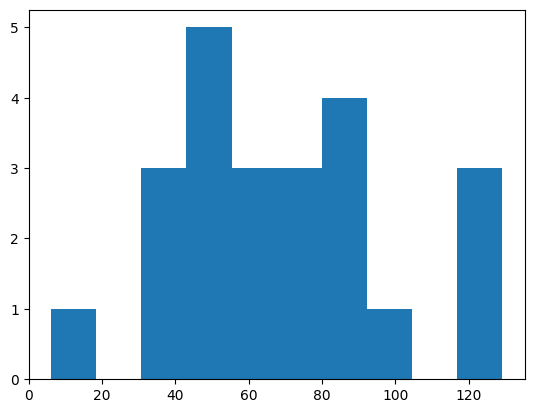

In [68]:
fig, ax = plt.subplots()
ax.hist(np.degrees(df_pca['pc1_angle']))

In [1]:
from datetime import datetime
from os.path import join
import os
from pprint import pprint
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.stats import entropy
import scipy.stats as stats
import scipy.optimize
import pickle
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from one.api import ONE
from brainbox.io.one import SessionLoader, EphysSessionLoader
from brainbox.processing import bincount2D
from iblatlas.atlas import AllenAtlas
from brainbox.io.one import SpikeSortingLoader

from psychedelic_functions import paths
from psychedelic_functions import fetch_spikes, _get_binned_spike_counts
from psychedelic_functions import combine_regions

ba = AllenAtlas(res_um=10)
path_dict = paths()
mode = 'auto'  # sets mode for all queries (one.seach* methods)
one = ONE(mode=mode)

/home/openlab/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


Downloading: /home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/tmppwv14s5x/cache.zip Bytes: 139369668


100%|██████████| 132.91327285766602/132.91327285766602 [00:15<00:00,  8.54it/s]


In [96]:


def get_categorical_epochs (idx):
    """
    Generate a dictionary of epoch boundaries for a given recording, based on passive task events
    and fixed [window_size]s intervals between the two runs of the passive task (window size is not
    a parameter in this one because modifying it will need changing other things in the function,
    keep to 300s or adjust the number of windows in the post_LSD period to match the new window 
    size).

    This function takes an index corresponding to a recording session and a window size,
    and returns a dictionary where keys correspond to named epochs (e.g., 'post_LSD_01_start')
    and values are the times within the recording at which these epochs start or stop.

    Parameters
    ----------
    idx : int or str
        The index of the recording session in the df_timings dataframe.
    window_size : int, optional
        The size, in seconds, of the window used to segment the recording
        into post-LSD epochs. Default is 300 (5 minutes).

    Returns
    -------
    dict
        A dictionary of epoch boundaries for the recording. Keys are epoch names (str) and
        values are boundary times (float).
    """
    window_size = 300
    epochs = {}
    epochs ['spontaneous_00_start'] = df_timings.loc[idx, f'spontaneous_start_00']
    epochs ['spontaneous_00_stop']  = df_timings.loc[idx, f'spontaneous_stop_00']
    epochs ['task_replay_00_start'] = df_timings.loc[idx, f'rfm_stop_00']      #USING RFM_STOP INSTEAD OF REPLAY_START
    epochs ['task_replay_00_stop']  = df_timings.loc[idx, f'replay_stop_00']
    epochs ['post_LSD_00_start']    = df_timings.loc[idx, 'admin_time'] + 0*(window_size)
    epochs ['post_LSD_00_stop']     = df_timings.loc[idx, 'admin_time'] + 1*(window_size)
    epochs ['post_LSD_01_start']    = df_timings.loc[idx, 'admin_time'] + 1*(window_size)
    epochs ['post_LSD_01_stop']     = df_timings.loc[idx, 'admin_time'] + 2*(window_size)
    epochs ['post_LSD_02_start']    = df_timings.loc[idx, 'admin_time'] + 2*(window_size)
    epochs ['post_LSD_02_stop']     = df_timings.loc[idx, 'admin_time'] + 3*(window_size)
    epochs ['post_LSD_03_start']    = df_timings.loc[idx, 'admin_time'] + 3*(window_size)
    epochs ['post_LSD_03_stop']     = df_timings.loc[idx, 'admin_time'] + 4*(window_size)
    epochs ['post_LSD_04_start']    = df_timings.loc[idx, 'admin_time'] + 4*(window_size)
    epochs ['post_LSD_04_stop']     = df_timings.loc[idx, 'admin_time'] + 5*(window_size)
    epochs ['post_LSD_05_start']    = df_timings.loc[idx, 'admin_time'] + 5*(window_size)
    epochs ['post_LSD_05_stop']     = df_timings.loc[idx, 'admin_time'] + 6*(window_size)
    epochs ['spontaneous_01_start'] = df_timings.loc[idx, f'spontaneous_start_01']
    epochs ['spontaneous_01_stop']  = df_timings.loc[idx, f'spontaneous_stop_01']
    epochs ['task_replay_01_start'] = df_timings.loc[idx, f'rfm_stop_01']      #USING RFM_STOP INSTEAD OF REPLAY_START
    epochs ['task_replay_01_stop']  = df_timings.loc[idx, f'replay_stop_01']
    return epochs

def get_sliding_epochs (idx, window_size = 300, window_step = 60):
    """
    Generate a dictionary of epoch boundaries for a sliding window analysis. In this 
    case, the windows are generated only based on the window_size and window_step 
    parameters, taking into account the length of the recording. The parameters can be
    changed in this one and no other modifications should be needed. 

    This function divides a session into overlapping epochs (or windows) of a 
    specified size, with the given step length, starting from the spontaneous activity 
    segment. 

    Parameters
    ----------
    idx : int or str
        The index of the recording session in the df_timings dataframe.
    window_size : int, optional
        The size, in seconds, of the window used to segment the recording. 
        Default is 300s (5 minutes).
    window_step : int, optional
        The number of seconds by which the window is shifted for the 
        creation of the next epoch. Default is 60s (1 minute).

    Returns
    -------
    dict
        A dictionary of epoch boundaries for the recording. Keys are epoch 
        names (str) (which include the window size, step size and epoch number),
        and values are boundary times (float).
    """
    epochs = {}
    epochs ['first_window_start'] = df_timings.loc[idx, f'spontaneous_start_00']
    epochs ['first_window_stop'] = df_timings.loc[idx, f'spontaneous_start_00'] + window_size

    counter = 0
    current_last_window = 0
    while current_last_window <= df_timings.loc[idx, f'replay_stop_01']:
        counter += 1
        epochs [f'{window_size}sWindow_{window_step}sStep_#{counter}_start'] = df_timings.loc[idx, f'spontaneous_start_00'] + (window_step * counter)
        epochs [f'{window_size}sWindow_{window_step}sStep_#{counter}_stop'] = df_timings.loc[idx, f'spontaneous_start_00'] + window_size + (window_step * counter)
        current_last_window = df_timings.loc[idx, f'spontaneous_start_00'] + window_size + (window_step * counter)
    return epochs

def create_epochs_dataframe(df_spikes, window_size = 300, windows = 'categorical', window_step = 60):
    """
    Generate a DataFrame with epoch boundaries for multiple recording sessions.

    This function takes a DataFrame with spike data, window size and type, 
    and step size. It applies either the get_categorical_epochs or get_sliding_epochs
    function to each recording session in the data, and compiles the results
    into a single DataFrame.

    Parameters
    ----------
    df_spikes : pandas.DataFrame
        A DataFrame containing spike data. Must have an 'eid' column that groups
        spikes into recording sessions.
    window_size : int, optional
        The size, in seconds, of the window used to segment the recording. 
        Default is 300s.
    windows : str, optional
        The type of epoch to use. If 'categorical', categorizes epochs based on 
        experimental conditions. If 'sliding', creates overlapping epochs based on 
        the provided window size and step. Default is 'categorical'.
    window_step : int, optional
        The step size for sliding windows, ignored if windows is not 'sliding'. 
        Default is 60s.

    Returns
    -------
    pandas.DataFrame
        A DataFrame where each row corresponds to a recording session and 
        columns represent different epochs within that session. Values are 
        epoch boundary times.
    """
    epochs_for_all_sessions = {}
    for idx, session in df_spikes.groupby(['eid']): 
        if windows == 'categorical':
            epochs = get_categorical_epochs (idx = idx, window_size = window_size)
            # epochs_for_all_sessions.append(epochs)
            epochs_for_all_sessions [f'{idx}'] = epochs
        elif windows == 'sliding':
            epochs = get_sliding_epochs (idx = idx, window_size = window_size, window_step = window_step)
            # epochs_for_all_sessions.append(epochs)
            epochs_for_all_sessions [f'{idx}'] = epochs
    df_epochs = pd.DataFrame (epochs_for_all_sessions)
    return df_epochs.T

def run_pca(df_spikes, idx, session, start, stop, plot = False):
    """
    Run Principle Component Analysis (PCA) on a window of a single recording session.

    This function extracts a chunk of recording data determined by the start and stop
    timestamps. It next normalizes the data, runs PCA, calculates the decay of the 
    explained variance per component (PCA spectrum), and computes the entropy of the
    PCA spectrum.

    Parameters
    ----------
    df_spikes : pandas.DataFrame
        DataFrame containing spike data.
    idx : int or str
        The index of the recording session in the df_timings dataframe.
    session : pandas.DataFrame
        A DataFrame containing spike data for a single recording session.
    start, stop : float
        Time points specifying the start and stop of the window in the recording session.
    plot : bool, optional
        If True, plot the variance explained per component. Default is False.

    Returns
    -------
    dict
        A dictionary containing the first principle component's variance explained,
        the variance explained by all components, the tau (exponential decay rate of the 
        PCA spectrum), and the normalized spectral entropy.
    """
    args = {'start': start, 'stop': stop}
    args['dt'] = 0.1
    spike_counts = session.apply(_get_binned_spike_counts, **args, axis='columns')
    X = np.column_stack(spike_counts) 
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    pca = PCA()
    pca.fit(X_norm)
    [tau], _ = scipy.optimize.curve_fit(exponential, np.arange(pca.n_components_), pca.explained_variance_ratio_/pca.explained_variance_ratio_[0])
    dict_measures = {}
    dict_measures[f'pc1'] = pca.explained_variance_ratio_[0]
    dict_measures[f'pcs'] = pca.explained_variance_ratio_
    dict_measures[f'tau'] = tau
    dict_measures[f'ngsc'] = entropy(pca.explained_variance_ratio_) / np.log2(pca.n_components_)
    if plot == True:
        fig, ax = plt.subplots()
        ax.plot(pca.explained_variance_ratio_)
        ax.set_xlabel('Component number')
        ax.set_ylabel(f'Variance explained')
        ax.set_title(f'Variance explained per component for session  \n {idx}')
    return dict_measures

def get_df_pca (df_spikes, df_epochs):
    """
    Computes PCA for each recording session and epoch.

    Iterates over each recording session in the df_spikes DataFrame, and for 
    each session, iterates over each epoch in df_epochs, computing PCA for 
    the given epoch using the run_pca function.

    Parameters
    ----------
    df_spikes : pandas.DataFrame
        A DataFrame containing spike data. Must have an 'eid' column that groups
        spikes into recording sessions.
    df_epochs : pandas.DataFrame
        A DataFrame where each row corresponds to a recording session and 
        columns represent different epochs within that session, with the values
        being the corresponding timings for each epoch in each session.

    Returns
    -------
    pandas.DataFrame
        A DataFrame where rows represent different recording sessions and columns 
        correspond to different epochs. Each cell in the DataFrame is itself a 
        dictionary, which includes the variance explained by the first principal 
        component, tau, the variance explained by all components, and the 
        normalized spectral entropy.
    """
    pca_per_idx = {}
    for idx, session in df_spikes.groupby(['eid']): 
        pca_per_epoch = {}
        for i, epoch in enumerate(df_epochs.keys()):
            if 'start' in epoch:
                epoch_start = df_epochs.keys()[i]
                epoch_stop  = df_epochs.keys()[i+1]
                if df_epochs[epoch_start].isna().any() or df_epochs[epoch_stop].isna().any():
                    continue
                start = df_epochs [f'{epoch_start}'][f'{idx}']       
                stop  = df_epochs [f'{epoch_stop}'][f'{idx}']     
                pca_results = run_pca(df_spikes, idx, session, start = start, stop = stop, plot = False)
                pca_per_epoch [f'{epoch_start} - {epoch_stop}'] = pca_results
            elif 'stop' in epoch:
                continue
        pca_per_idx[f'{idx}'] = pca_per_epoch
    df_pca = pd.DataFrame(pca_per_idx)
    return df_pca.T

def align_epochs_admin_is_zero(df_pca, df_timings):
    # Makes sense only when running create_epochs_dataframe with parameters window_size = 60, window_step = 60, windows = 'sliding'
    """
    Aligns epochs in PCA results DataFrame with administration times from timings DataFrame.

    Find the epoch containing the administration time point for each session, and shift the data 
    so that this epoch aligns with the epoch in other sessions. Fill the gaps with NaNs.

    Parameters
    ----------
    df_pca : pandas.DataFrame
        DataFrame with PCA results. Rows represent different recording sessions,
        and columns represent different one-minute epochs.
    df_timings : pandas.DataFrame
        DataFrame with timing information for administration events. Should have a 'admin_times' column.

    Returns
    -------
    df_pca_aligned : pandas.DataFrame
        DataFrame of the same shape as df_pca, but with epochs aligned to the administration time.
    """
    df_pca_aligned = pd.DataFrame(index=df_pca.index, columns=df_pca.columns)

    for session in df_pca.index:
        admin_time = df_timings.loc[session, 'admin_time']
        epoch_index = int(admin_time // 60)  # identify epoch by integer division
        df_pca_aligned.loc[session] = df_pca.loc[session].shift(-epoch_index)

    return df_pca_aligned.dropna(axis=1, how='any')

def align_epochs_admin_is_max_shift(df_pca, df_timings):
    # Makes sense only when running create_epochs_dataframe with parameters window_size = 60, window_step = 60, windows = 'sliding'
    # To plot red line on admin time add the returned admin_aligned as a parameter for plot_metrics_evolutions_divided_norm

    """
    Align df_pca to admin_time. This function creates a wider dataframe to be able to accomodate the shifted rows from df_pca. Rows
    in df_pca are aligned based on the epoch that contains admin_time, then copied to the new dataframe. The resulting dataframe has
    NaNs in the entries around each row, and before returning it all columns containing NaNs are dropped, meaning that in the resulting
    dataframe all rows are aligned to admin time, but some datapoints are lost in the beginning or end of each session, depending on
    how it was shifted. At the time of testing this, the difference between the earliest and latest admin times recorded was 7 min,
    and that is the difference between the plots before and after aligning. 

    Parameters
    ----------
    df_pca : pandas.DataFrame
        The PCA DataFrame with rows representing different sessions and columns corresponding to different epochs to be aligned.

    df_timings : pandas.DataFrame
        A DataFrame containing administration times with session identifiers that match those in df_pca.

    Returns
    -------
    df_pca_shifted : pandas.DataFrame
        A new DataFrame where the columns (epochs) have been shifted according to the administration times. The difference between the
        number of columns in this dataframe and the number of columns of the original input dataframe is equal to the difference between
        the earliest and latest admin_times recorded in df_timings. 

    max_shift : int 
        Maximum observed administration time shift which determines the number of columns added to the DataFrame.
    """
    max_shift = max(df_timings['admin_time'] // 60)
    min_shift = min(df_timings['admin_time'] // 60)
    admin_spread = max_shift - min_shift
    # Create empty DataFrame with more columns
    df_pca_shifted = pd.DataFrame(index=df_pca.index, columns=range(len(df_pca.columns) + int(max_shift)))

    for session in df_pca.index:
        admin_time = df_timings.loc[session, 'admin_time']
        admin_epoch_id = int(admin_time // 60)
        shift_position = admin_epoch_id + (max_shift - admin_epoch_id) #THIS IS WHAT IS MAKING IT ALIGN WRONGLY, INSTEAD OF ADJUSTING FOR ADMIN TIME ITS REALIGNING THEM TO ORIGINAL SHAPE
        # Place shifted row values into new DataFrame
        df_pca_shifted.loc[session, shift_position : shift_position + len(df_pca.columns) - 1] = df_pca.loc[session].values
    
    df_pca_aligned = df_pca_shifted.dropna(axis = 1)

    df_pca_aligned.reset_index(drop=True, inplace=True)

    admin_aligned = max_shift-admin_spread

    return df_pca_aligned, admin_aligned

def plot_compared_metrics (df_pca):
    """
    Creates comparison plots for three measures across all epochs in a DataFrame.

    For each column in the input DataFrame, this function creates a figure
    with 6 subplots. The first row of plots show scatter plots of the PC1 
    variance, tau and ngsc values for the first epoch and the current epoch in
    comparison. The second row shows scatter plots comparing the corresponding 
    measure from the first epoch (X axis) against the current epoch (Y axis).
    
    Parameters
    ----------
    df_pca : pandas.DataFrame
        A DataFrame where each row represents a different recording session
        and each column corresponds to a different epoch. Each cell in this 
        DataFrame is a dictionary, which includes the variance explained by 
        the first principal component, tau, the variance explained by all 
        components, and the normalized spectral entropy.

    Returns
    -------
    None
        This function only creates plots and does not return anything.
    """
    measures = ['pc1', 'tau', 'ngsc']  # list of measures
    titles = ['Variance explained by PC1', 'Tau from exponential fit on variance explained distribution', 'NGSC score']
    colors = ['b', 'g', 'r']  # Set different colors for different plots
    line_dims = [[0,0.5], [0,10], [0.5, 0.8]]

    for column in df_pca.columns[::]:
        print(column)
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # change layout to 2 rows, 3 cols
        fig.suptitle(f'Comparison window: {column}')

        for i, measure in enumerate(measures):
            reference_window = df_pca[df_pca.columns[0]].apply(lambda x: x[measure])
            comparison_window = df_pca[column].apply(lambda x: x[measure])

            axs[0, i].scatter(np.arange(len(reference_window)), reference_window, facecolors='none', edgecolors=colors[i], label=f'{measure} Reference')
            axs[0, i].scatter(np.arange(len(comparison_window)), comparison_window, color=colors[i], label=f'{measure} Comparison')
            
            axs[1, i].scatter(reference_window, comparison_window, color=colors[i], label=column)
            axs[1, i].plot(line_dims[i], line_dims[i], color='r')

            ttest_result = scipy.stats.ttest_rel(reference_window, comparison_window)
            ttest_result_str = "statistic={:.3f}, pvalue={:.4f}".format(ttest_result.statistic, ttest_result.pvalue)
            
            axs[0, i].set_title(ttest_result_str, fontsize=9)
            axs[1, i].set_title(ttest_result_str, fontsize=9)
            
            axs[0, i].set_ylabel(titles[i])  # set corresponding Y axis title
            axs[0, i].set_xlabel("Session ID")  # set X axis title
            axs[0, i].set_xticks([])  # remove X axis ticks

            if measure == 'pc1':
                axs[1, i].set_xlabel(f"Variance explained by {measure} in first window")
                axs[1, i].set_ylabel(f"Variance explained by {measure} in second window")
            else:
                axs[1, i].set_xlabel(f"{measure} values for first window")
                axs[1, i].set_ylabel(f"{measure} values for second window")
            
            axs[0, i].legend()
            # axs[1, i].legend()

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        plt.close()

def plot_metrics_evolutions (df_pca):
    """
    Plot the evolution of the specified measures across epochs.

    This function iterates over different measures ('pc1', 'tau', 'ngsc'), 
    compiling all respective values and their change relative to the first 
    epoch. The evolutions of these measures and their changes are then plotted over all epochs.

    Parameters
    ----------
    df_pca : pandas.DataFrame
        A DataFrame where each row represents a different recording session
        and each column corresponds to a different epoch. Each cell is a 
        dictionary which includes the variance explained by the first principal 
        component, tau, the variance explained by all components, and the 
        normalized spectral entropy.

    Returns
    -------
    None
        This function only creates plots and does not return anything.
    """
    # Set measures
    measures = ['pc1', 'tau', 'ngsc']  

    fig, axs = plt.subplots(len(measures), 2, figsize=(20, 5*len(measures)))

    significance_threshold = 1  # Modify this value accordingly

    for i, measure in enumerate(measures):
        all_values = []
        all_deltas = []
        for session in df_pca.index:
            values = []
            deltas = []
            for epoch in df_pca.columns:
                value = df_pca.loc[session, epoch][measure]
                values.append(value)
                deltas.append(value - values[0])

            all_values.append(values)
            all_deltas.append(deltas)

            axs[i, 0].plot(values, color='gray', linewidth=0.5)
            axs[i, 1].plot(deltas, color='gray', linewidth=0.5)

        # Calculate average and SEM
        avg_values = np.mean(all_values, axis=0)
        avg_deltas = np.mean(all_deltas, axis=0)

        sem_deltas = stats.sem(all_deltas)

        axs[i, 1].errorbar(range(len(avg_deltas)), avg_deltas, yerr=sem_deltas, color='black', linewidth=1.5, label="Average")

        # # Add asterisks for significant mean values
        # for index, avg_delta in enumerate(avg_deltas):
        #     if abs(avg_delta) > significance_threshold:
        #         axs[i, 1].text(index, avg_delta, '*', ha='center', va='bottom')

        # Formatting for both plots
        for j in range(2):
            axs[i, j].set_xticks(range(len(df_pca.columns)))
            
            if j == 1:
                axs[i, j].axhline(0, color='red', linewidth=0.5)
                axs[i, j].set_title(f'{measure} (normalized) evolution throughout the epochs')
            else:
                axs[i, j].set_title(f'{measure} evolution throughout the epochs')

            if i < len(measures) - 1:
                axs[i, j].set_xticklabels([])
            else:
                axs[i, j].set_xticklabels(df_pca.columns, rotation=45, ha="right")
                axs[i, j].set_xlabel('Epochs')

            axs[i, j].legend() 

    plt.tight_layout(h_pad=0.0, w_pad=2.0)
    plt.show()

def plot_metrics_evolutions_divided_norm (df_pca, window = 'categorical', admin_aligned = None):
    """
    Plot the evolution of specified measures across epochs as ratios normalized by the first value.

    For each specified measure ('pc1', 'tau', 'ngsc'), this function gathers all respective 
    values as ratios normalized by the first value of the measure. It then plots the evolutions 
    of these measures and their ratios over all epochs.

    If a value is provided for admin_aligned, a red vertical line will be plotted there.

    Parameters
    ----------
    df_pca : pandas.DataFrame
        A DataFrame where each row represents a different recording session and each 
        column corresponds to a different epoch. Each DataFrame cell is a dictionary
        which includes the variance explained by the first principal component, tau,
        the variance explained by all components, and the normalized spectral entropy.
    window : str, optional
        The type of window used, "categorical" or "sliding". Default is "categorical".

    Returns
    -------
    None
        This function only creates plots and does not return anything.
    """
    # Set measures
    measures = ['pc1', 'tau', 'ngsc']  

    fig, axs = plt.subplots(len(measures), 2, figsize=(20, 5*len(measures)))

    for i, measure in enumerate(measures):
        all_values = []
        all_ratios = []  # normalized values
        for session in df_pca.index:
            values = []
            ratios = []  # normalized values
            for epoch in df_pca.columns:
                epoch_data = df_pca.loc[session, epoch]
                if epoch_data is not None and not pd.isna(epoch_data):
                    value = epoch_data[measure]
                    values.append(value)
                    if len(values) > 0:
                        ratios.append(value / values[0])  # normalize to the first value

            all_values.append(values)
            all_ratios.append(ratios)

            axs[i, 0].plot(values, color='gray', linewidth=0.5)
            axs[i, 1].plot(ratios, color='gray', linewidth=0.5)

        # Calculate averages and SEM for the ratios
        avg_ratios = np.mean(all_ratios, axis=0)
        sem_ratios = stats.sem(all_ratios)

        axs[i, 1].errorbar(range(len(avg_ratios)), avg_ratios, yerr=sem_ratios, color='black', linewidth=1.5, label="Average")

        # Formatting for both plots
        for j in range(2):
            axs[i, j].set_xticks(range(len(df_pca.columns)))
            
            if admin_aligned is not None:
                
                axs[i, j].axvline(admin_aligned, color='red', linewidth=0.5)  # Draw a vertical red line at admin_aligned
            if j == 1:
                axs[i, j].axhline(1, color='black', linewidth=0.5)  # since data is now a ratio, expect mean around 1
                axs[i, j].set_title(f'{measure} (normalized by first value) evolution throughout the epochs')
            else:
                axs[i, j].set_title(f'{measure} evolution throughout the epochs')

            if i < len(measures) - 1:
                axs[i, j].set_xticklabels([])
            else:
                axs[i, j].set_xticklabels(df_pca.columns, rotation=45, ha="right")
                axs[i, j].set_xlabel('Epochs')

            axs[i, j].legend() 

    plt.tight_layout(h_pad=0.0, w_pad=2.0)
    plt.show()


In [57]:
window_size = 60
window_step = 60
windows = 'sliding'  # 'sliding'/'categorical'

df_spikes = pd.read_pickle('data/spike_times.pkl')
df_timings = pd.read_csv('metadata/timings.csv').set_index('eid')
df_timings = df_timings.dropna()
df_spikes = df_spikes[np.isin(df_spikes['eid'], df_timings.index)]
df_spikes = df_spikes.dropna()
df_epochs = create_epochs_dataframe(df_spikes, window_size = window_size, windows = windows, window_step = window_step)
df_pca = get_df_pca (df_spikes, df_epochs)


/tmp/ipykernel_1979531/90147162.py:146: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for idx, session in df_spikes.groupby(['eid']):
/tmp/ipykernel_1979531/90147162.py:237: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for idx, session in df_spikes.groupby(['eid']):


In [97]:

#CHECK MAX_SHIFT, I DON'T THINK THAT ACTUALLY  ENDS UP BEING THE ADMIN TIME THAT'S ALIGNED ACCROSS.
df_pca_aligned = align_epochs_admin_is_max_shift(df_pca, df_timings)
# # df_pca_aligned, admin_aligned = align_epochs_admin_is_max_shift(df_pca, df_timings)


# plot_metrics_evolutions_divided_norm (df_pca)
# plot_metrics_evolutions_divided_norm (df_pca_aligned, admin_aligned= admin_aligned)
# # plot_metrics_evolutions_divided_norm (df_pca_aligned)

In [98]:
df_pca_aligned

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0bd26d4d-c1c1-4f59-af13-59d19b597ab6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'pc1': 0.10743545018794202, 'pcs': [0.1074354...","{'pc1': 0.1108191207042988, 'pcs': [0.11081912...","{'pc1': 0.11070211955820472, 'pcs': [0.1107021...","{'pc1': 0.10155628999030199, 'pcs': [0.1015562...","{'pc1': 0.09985898568228056, 'pcs': [0.0998589...","{'pc1': 0.09872731020762227, 'pcs': [0.0987273...","{'pc1': 0.09514058582571071, 'pcs': [0.0951405...","{'pc1': 0.10150685391164539, 'pcs': [0.1015068...","{'pc1': 0.1189781680428701, 'pcs': [0.11897816...","{'pc1': 0.10644606186712616, 'pcs': [0.1064460..."
1cbb24d0-2188-45dc-a116-e23a089c62b4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'pc1': 0.12277213361194671, 'pcs': [0.1227721...","{'pc1': 0.11400761695029789, 'pcs': [0.1140076...","{'pc1': 0.11131737736222448, 'pcs': [0.1113173...","{'pc1': 0.11506642921682486, 'pcs': [0.1150664...","{'pc1': 0.08329424532080132, 'pcs': [0.0832942...","{'pc1': 0.117962839909869, 'pcs': [0.117962839...","{'pc1': 0.1030034305147498, 'pcs': [0.10300343...","{'pc1': 0.12627745563502482, 'pcs': [0.1262774...","{'pc1': 0.11925781641941516, 'pcs': [0.1192578...","{'pc1': 0.13533622387107141, 'pcs': [0.1353362..."
2583567d-cd2a-485a-8d79-85aa619e1ce2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'pc1': 0.11481791688769641, 'pcs': [0.1148179...","{'pc1': 0.08913166187102382, 'pcs': [0.0891316...","{'pc1': 0.10186063324843209, 'pcs': [0.1018606...","{'pc1': 0.07451759145747498, 'pcs': [0.0745175...","{'pc1': 0.1030872230612703, 'pcs': [0.10308722...","{'pc1': 0.08402823168145393, 'pcs': [0.0840282...","{'pc1': 0.09735617686968245, 'pcs': [0.0973561...","{'pc1': 0.1021451426241886, 'pcs': [0.10214514...","{'pc1': 0.08346354505968784, 'pcs': [0.0834635...","{'pc1': 0.09702249136351594, 'pcs': [0.0970224..."
4b398979-c54c-498f-a3d4-b201c2285be5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'pc1': 0.08114306593237754, 'pcs': [0.0811430...","{'pc1': 0.052493039231210084, 'pcs': [0.052493...","{'pc1': 0.07152289401501634, 'pcs': [0.0715228...","{'pc1': 0.07360021231266076, 'pcs': [0.0736002...","{'pc1': 0.05114848013907332, 'pcs': [0.0511484...","{'pc1': 0.07098134621738224, 'pcs': [0.0709813...","{'pc1': 0.0614873934755496, 'pcs': [0.06148739...","{'pc1': 0.082692680215524, 'pcs': [0.082692680...","{'pc1': 0.07753294927165699, 'pcs': [0.0775329...","{'pc1': 0.07741912665089708, 'pcs': [0.0774191..."
50322fbb-5b93-46d7-9ca0-391fa30c966a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'pc1': 0.08874431383431271, 'pcs': [0.0887443...","{'pc1': 0.07645827435168673, 'pcs': [0.0764582...","{'pc1': 0.09476719061147308, 'pcs': [0.0947671...","{'pc1': 0.09106069661777279, 'pcs': [0.0910606...","{'pc1': 0.08712677807758135, 'pcs': [0.0871267...","{'pc1': 0.07307035966749688, 'pcs': [0.0730703...","{'pc1': 0.08098011517017982, 'pcs': [0.0809801...","{'pc1': 0.08028196552971521, 'pcs': [0.0802819...","{'pc1': 0.13352240599161802, 'pcs': [0.1335224...","{'pc1': 0.07307125285321667, 'pcs': [0.0730712..."
53d8cb2f-3338-4bcd-81c4-6207b660eba3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'pc1': 0.11038425210524949, 'pcs': [0.1103842...","{'pc1': 0.10569408194989864, 'pcs': [0.1056940...","{'pc1': 0.10059791783388501, 'pcs': [0.1005979...","{'pc1': 0.10846492383529084, 'pcs': [0.1084649...","{'pc1': 0.12047641216031933, 'pcs': [0.1204764...","{'pc1': 0.12114300798424628, 'pcs': [0.1211430...","{'pc1': 0.08870096800464237, 'pcs': [0.0887009...","{'pc1': 0.11120933152368388, 'pcs': [0.1112093...","{'pc1': 0.08888437689277913, 'pcs': [0.0888843...","{'pc1': 0.1063546451168806, 'pcs': [0.10635464..."
6dc3fee9-6bfc-4daf-a70f-d726ac2fcfde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'pc1': 0.08641652696358651, 'pcs': [0.0864165...","{'pc1': 0.09285366305715337, 'pcs': [0.0928536...","{'pc1': 0.09019332148612391, 'pcs': [0.0901933...","{'pc1': 0.12656195202076823, 'pcs': [0.1265619...","{'pc1': 0.09773634701498277, 'pcs': [0.0977363...